<a href="https://colab.research.google.com/github/KlaidasKaralevicius/Computer_vision_project/blob/main/CV_crowd_counting_classic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dependencies

In [ ]:
import numpy as np
import cv2
import os
import random
from scipy.ndimage import gaussian_filter
from scipy.io import loadmat
from google.colab.patches import cv2_imshow

# Full set
!gdown --id 1zS9LCWu3sOcIjB477mluRQWmGaOgUa2f -O /content/ShanghaiTechTest.zip
!unzip /content/ShanghaiTechTest.zip -d /content/

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1zS9LCWu3sOcIjB477mluRQWmGaOgUa2f
From (redirected): https://drive.google.com/uc?id=1zS9LCWu3sOcIjB477mluRQWmGaOgUa2f&confirm=t&uuid=e062df50-ee55-4bea-8a9e-5e12daf92dee
To: /content/ShanghaiTechTest.zip
100% 174M/174M [00:03<00:00, 55.0MB/s]
Archive:  /content/ShanghaiTechTest.zip
   creating: /content/ShanghaiTech/
   creating: /content/ShanghaiTech/part_A/
   creating: /content/ShanghaiTech/part_A/test_data/
   creating: /content/ShanghaiTech/part_A/test_data/ground-truth/
 extracting: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_1.mat  
 extracting: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_10.mat  
 extracting: /content/ShanghaiTech/part_A/test_data/ground-truth/GT_IMG_10

# Load dataset

In [ ]:
# load .mat file and return people count
def load_gt_mat(mat_path):
    mat = loadmat(mat_path)
    return len(mat['image_info'][0][0][0][0][0])

# load image and ground truth count
def load_sample(img_path, gt_path):
    img = cv2.imread(img_path)
    gt_coords = load_gt_mat(gt_path)
    return img, gt_coords

# load dataset (train or test set with image and corresponding ground truth)
def load_dataset(base_path, dataset_type):
    images = []
    gts = []
    img_dir = os.path.join(base_path, f'{dataset_type}_data', 'images')
    gt_dir = os.path.join(base_path, f'{dataset_type}_data', 'ground-truth')

    # get matching .mat and .jpg
    for img_file in os.listdir(img_dir):
        if img_file.endswith('.jpg'):
            # find img and convert its name to mat to find matching pair
            # (pvz. IMG_1, add GT_ before and change jpg to mat to find matching mat file -> IMG_1.jpg = GT_IMG_1.mat)
            img_path = os.path.join(img_dir, img_file)
            gt_file = 'GT_' + img_file.replace('.jpg', '.mat')
            gt_path = os.path.join(gt_dir, gt_file)

            if os.path.exists(gt_path):
                image, gt_coords = load_sample(img_path, gt_path)
                images.append(image)
                gts.append(gt_coords)

    return images, gts

# Preprocess

In [ ]:
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # boost contrast
    clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(4, 4)) # boost contrast by increasing histogram bin height in the grid, then blend borders
    gray = clahe.apply(gray)

    # gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (3, 3), 0)
    return blurred

# Threshold and separation

In [ ]:
# split image in white (possible people) and black (background and similar)
def get_threshold(preprocessed):
    # splits in white and black
    thresh = cv2.adaptiveThreshold(
        preprocessed, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        11, 2 # take a 11x11 block, centered on the centerl pixel, apply thresholding on all pixels based on local gaussian sum (center pixels matter more), if above threshold, become white, then invert
    )

    # remove small noise, like dots, keep big white regions
    kernel = np.ones((2, 2), np.uint8)
    # slyghtly grows white regions to connect broken parts
    clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel) # shrink white regions to remove noise
    clean = cv2.dilate(clean, kernel) # grows region back to normal
    return clean

In [ ]:
def separate_connected_blobs(binary_img):
    # remove small noise
    kernel = np.ones((1, 1), np.uint8) # smaller better for dense crowds
    opening = cv2.morphologyEx(binary_img, cv2.MORPH_OPEN, kernel)

    # expand black to define - truly a background
    sure_bg = cv2.dilate(opening, kernel)

    # how far away white pixel from black
    dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    # normalize values 0-1
    dist = cv2.normalize(dist, None, 0, 1.0, cv2.NORM_MINMAX)
    # only keep strong areas (possible center of human head)
    _, sure_fg = cv2.threshold(dist, 0.12, 1.0, cv2.THRESH_BINARY) # if pixels distance >= than 0.08 it becomes 1, keeps the core of blobs
    # convert to 0-255
    sure_fg = np.uint8(sure_fg * 255)

    # black area between background and foreground, watershed will try to seperate this regions
    unknown = cv2.subtract(sure_bg, sure_fg)

    # give ID to foreground blobs
    _, markers = cv2.connectedComponents(sure_fg)
    # bacground = 1, unknown = 0
    markers = markers + 1
    markers[unknown == 255] = 0
    # watershed splits big connected blobs into smaller labeled blobs
    img_color = cv2.cvtColor(binary_img, cv2.COLOR_GRAY2BGR)
    markers = cv2.watershed(img_color, markers) # floods the map from the peaks, when 2 regions connect, draw the line at connection

    # only keep areas which label is > 1, only real regions
    result = np.zeros_like(binary_img)
    result[markers > 1] = 255
    return result

# Count

In [ ]:
def count_people(threshold):
    # detects contours, detect blobs -> retrieve outer contours -> store only key points
    contours, _ = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    points = []
    # filter out small noise
    min_size = 10

    for cnt in contours:
        # process only contours bigger than noise
        area = cv2.contourArea(cnt)
        if area > min_size:
            # find centroid
            M = cv2.moments(cnt)
            # find centroid coords
            if M['m00'] != 0:
                cx = int(M['m10'] / M['m00'])
                cy = int(M['m01'] / M['m00'])
                points.append((cx,cy))
    return points

# Plot results

In [ ]:
def plot_images(img, name):
    print(name)
    cv2_imshow(img)

def predict(img, gts=0, idx=None):
    if idx is not None:
        img = img[idx]
    else:
        img = cv2.imread(img)
    plot_images(img, 'original\n')
    preprocess = preprocess_image(img)

    threshold = get_threshold(preprocess)

    seperated = separate_connected_blobs(threshold)
    plot_images(seperated, 'seperated\n')

    seperated[seperated != 255] = 0
    points = count_people(seperated)
    if gts!=0 and idx is not None:
        print(f"predicted: {len(points)}; actual: {gts[idx]}")
    else:
        print(f"predicted: {len(points)}")

# Test run

In [ ]:
# load datasets
base_path = 'ShanghaiTech/part_A'

images, gts = load_dataset(base_path, 'test')

original



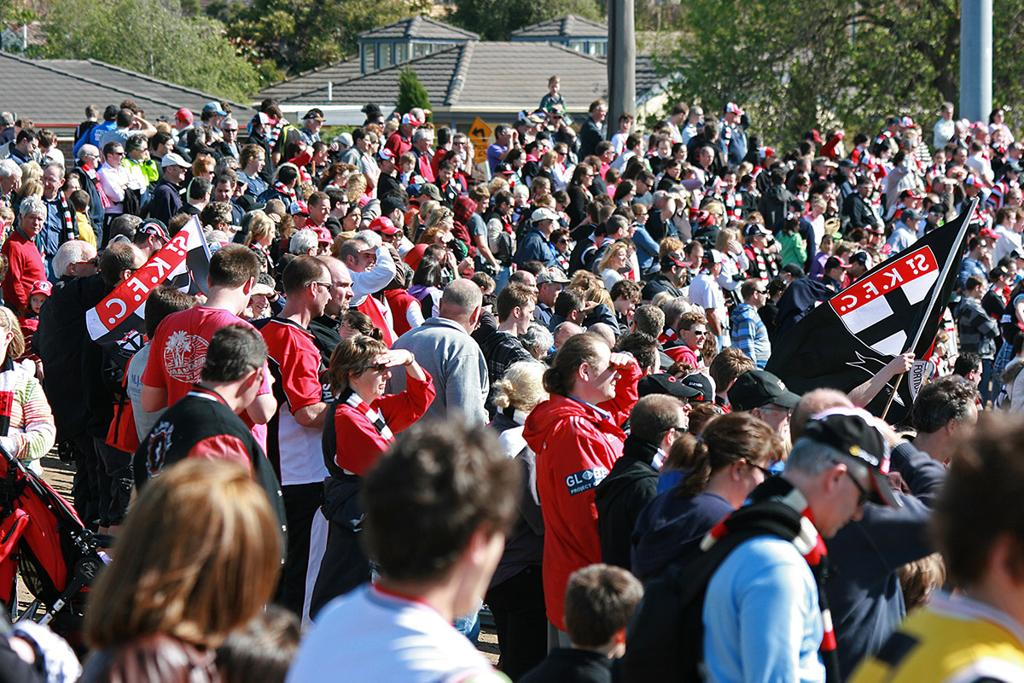

seperated



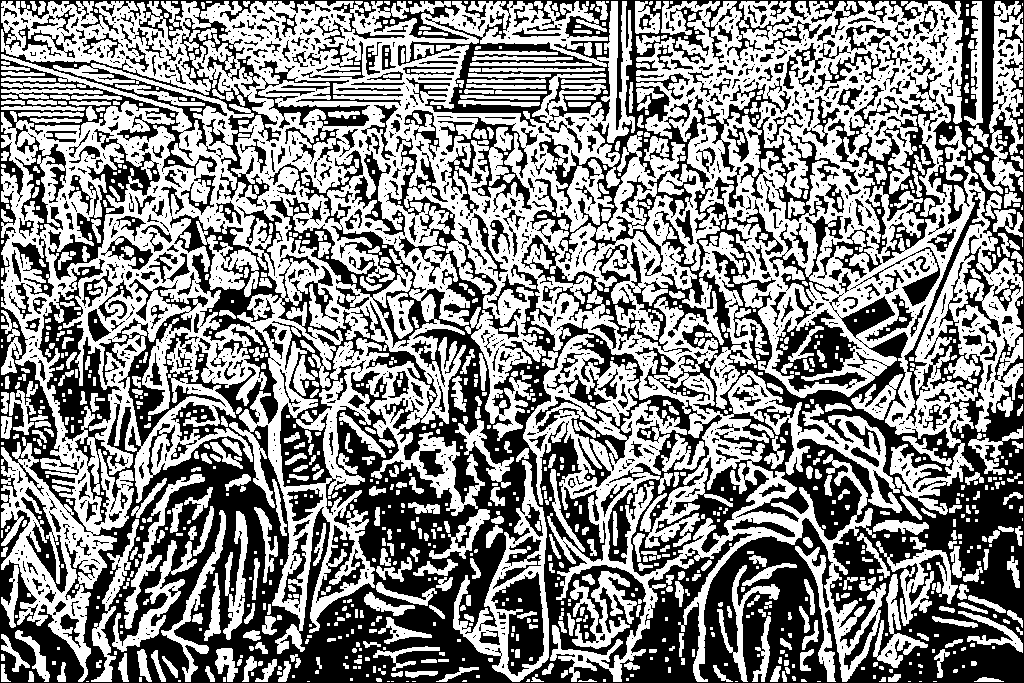

predicted: 316; actual: 271


In [ ]:
predict(images, gts, 6)

# Metrics

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr
from tqdm import tqdm

In [ ]:
def predict_count(img):
    preprocess = preprocess_image(img)
    threshold = get_threshold(preprocess)
    seperated = separate_connected_blobs(threshold)
    seperated[seperated != 255] = 0
    points = count_people(seperated)
    return len(points), points, seperated

In [ ]:
def evaluate_model(images, gts):
    predictions = []
    actual = []
    for img, gt in zip(tqdm(images), gts):
        pred, _, _ = predict_count(img)
        predictions.append(pred)
        actual.append(gt)
    mae = mean_absolute_error(actual, predictions)
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    mape = np.mean(np.abs((np.array(actual) - np.array(predictions)) / np.array(actual))) * 100
    r2 = r2_score(actual, predictions)
    return {
        'predictions': predictions,
        'actual': actual,
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2
    }

In [ ]:
def print_per_image_differences(results):
    actuals     = results['actual']
    preds       = results['predictions']
    print(f"{'Idx':>3} | {'Actual':>6} | {'Predicted':>9} | {'Diff':>6}")
    print("-"*32)
    for i, (a, p) in enumerate(zip(actuals, preds)):
        diff = p - a
        print(f"{i:>3} | {a:>6} | {p:>9} | {diff:>6}")

In [ ]:
def run_evaluation():
    images, gts = load_dataset(base_path, 'test')
    print("Running model evaluation...")
    results = evaluate_model(images, gts)

    print("\nMetrikos")
    print(f"MAE:  {results['mae']:.2f}")
    print(f"RMSE: {results['rmse']:.2f}")
    print(f"MAPE: {results['mape']:.2f}%")
    print(f"R2: {results['r2']:.4f}")

    print("\nSkirtumai:")
    print_per_image_differences(results)

In [ ]:
run_evaluation()

Running model evaluation...


100%|██████████| 182/182 [00:05<00:00, 30.49it/s]


Metrikos
MAE:  299.21
RMSE: 439.81
MAPE: 71.67%
R2: -6.4119

Skirtumai:
Idx | Actual | Predicted |   Diff
--------------------------------
  0 |    218 |       173 |    -45
  1 |    553 |       319 |   -234
  2 |    101 |       294 |    193
  3 |    239 |       469 |    230
  4 |    762 |       282 |   -480
  5 |    199 |       538 |    339
  6 |    271 |       316 |     45
  7 |   1603 |        58 |  -1545
  8 |    116 |       389 |    273
  9 |    670 |       112 |   -558
 10 |    568 |       209 |   -359
 11 |    133 |       175 |     42
 12 |    242 |       185 |    -57
 13 |    230 |       402 |    172
 14 |    309 |       320 |     11
 15 |   1111 |       206 |   -905
 16 |    529 |        91 |   -438
 17 |    219 |        85 |   -134
 18 |    261 |        95 |   -166
 19 |   1581 |       595 |   -986
 20 |    135 |        79 |    -56
 21 |    241 |       462 |    221
 22 |    138 |       386 |    248
 23 |    398 |       477 |     79
 24 |    479 |       264 |   -215
 25 |    3